Molly Peeples ([@astronomolly](https://twitter.com/astronomolly)) recently
tweeted [some really cool
plots](https://twitter.com/astronomolly/status/749675563539890176) from
[timeanddate.com](http://www.timeanddate.com/sun/uk/edinburgh) that visualize
local solar properties over a year from a location (e.g., twilights, solar noon,
etc.), e.g.:

![alt text](timeanddate.png "Edinburgh")


My first thought was: can we make those plots with Astropy? This post shows one
way to make figures like this in Python using [Astropy](http://www.astropy.org)
and [Matplotlib](http://www.matplotlib.org).

In [1]:
from datetime import datetime

# Third-party
import astropy.coordinates as coord
import astropy.units as u
import astropy.time as t
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

%matplotlib inline
import pytz

This code relies on a [brand new feature](https://github.com/astropy/astropy/pull/5154) of the
development version of Astropy that uses the Google maps API to allow you to get an
[EarthLocation](http://docs.astropy.org/en/latest/api/astropy.coordinates.EarthLocation.html)
object given any arbitrary address. For example, a fully-specified street address:

In [2]:
loc = coord.EarthLocation.of_address("1002 Holy Grail Court, St. Louis, MO")
loc.lon, loc.lat

(<Longitude -90.30694082 deg>, <Latitude 38.51432306 deg>)

A city name:

In [3]:
loc = coord.EarthLocation.of_address("Parrot, ME")
loc.lon, loc.lat

(<Longitude -69.5539404 deg>, <Latitude 45.2550505 deg>)

Or even a point of interest:

In [4]:
loc = coord.EarthLocation.of_address("Camelot Castle Hotel, Tintagel, UK")
# (it's only a model)
loc.lon, loc.lat

(<Longitude -4.75555277 deg>, <Latitude 50.6682136 deg>)

We'll use this feature to get an `EarthLocation` (e.g., latitude and longitude) for any city we'd like to make a sun graph for.

Next we define some more objects to define the various types of twilight. The first dictionary contains the sun altitude specifications for civil, nautical, and astronomical twilight (the range or minimum to maximum sun altitude for each). The next dictionary maps the names of the various stages of sunlight to integers that are ranked with the brightness. This will be used in plotting later on. 

In [5]:
_twil = {
    "civil": [-6.0, 0] * u.degree,
    "nautical": [-12.0, -6] * u.degree,
    "astronomical": [-18.0, -12] * u.degree,
}

_twil_name_map = {"day": 0, "civil": 1, "nautical": 2, "astronomical": 3, "night": 4}

Now we can write a function to make a sun plot for a given location! At minimum, the function will need to accept an `EarthLocation`, which contains the latitude/longitude information, and a `pytz` timezone information object. We'll write the function so that, by default, it produces a plot for the entire current year by computing the solar properties for every day. But, we should let the user have some control over this -- for example, if we want lower resolution over only three months of the year starting from May 15, it should be possible to specify a custom grid of days and a start date. The full function is somewhat long, so I will break it up into chunks and explain through each chunk in succession. Skip down to [the full function cell](#full-plot-function) to see the whole thing.

The first few lines of the plot function look at the inputs that specify the date grid over which we will compute the solar properties. The two relevant arguments are `start` and `day_grid`, and the possible combinations and specifications are:
* `start` is not specified and `day_grid` is not specified: this is the default and will produce a plot with solar properties for every day in a full year starting on January 1 of the current year.
* `start` is specified and `day_grid` is specified: if both are specified, we simply need to add the grid of days to the input start `astropy.time.Time` object.
* `start` is specified and `day_grid` is not specified: if the start datetime is specified but the grid of days isn't, it uses a grid of 1 year with a spacing of 1 day.
* `start` is not specified but `day_grid` is specified: assumes the start is January 1 of the current year.

In [6]:
def sun_info_plot1(
    earth_location, tz, start=None, day_grid=None, n_hour_grid=512, fig=None
):

    if start is None and day_grid is None:  # default
        year = datetime.now().year
        start = t.Time(f"{year}-01-01", format="iso", scale="utc")
        day_grid = start + np.arange(0, 365 + 1).astype(int) * u.day

    elif start is not None and day_grid is not None:
        day_grid = start + day_grid

    elif start is not None and day_grid is None:
        day_grid = start + np.arange(0, 365 + 1).astype(int) * u.day

    elif start is None and day_grid is not None:
        year = datetime.now().year
        start = t.Time(f"{year}-01-01", format="iso", scale="utc")
        day_grid = start + day_grid

    else:  # should never reach here
        raise ValueError("How did I get here?")

    # ...

Now we will loop through the days for which we will compute the solar properties, convert the local times to UTC, get the sun's position throughout the day and use our definitions of twilight to figure out at what times the conditions are met. We start by defining a 2D array: the 0th axis represents the grid of days throughout the year, and the 1st axis represents a grid of hours throughout each day when we will compute the solar properties. 

We now loop over each day in the year. For each day, we generate a grid of hours and convert these local times to UTC times. We then use [`astropy.coordinates.get_sun`](http://docs.astropy.org/en/latest/api/astropy.coordinates.get_sun.html#astropy.coordinates.get_sun) to get the position of the sun at each of these times, and transform these positions to the Altitude-Azimuth system using the input location on the Earth. Solar noon and midnight are computed as extrema of the altitude. For each type of twilight, we record the times at which the twilight constraints (defined above) are met by storing an integer in the 2D array `twil_grid` (0 corresponding to daytime, 1 for civil twilight, 2 for nautical twilight, etc. as defined above). Finally, when the sun is below -18º, we set it to night time.

In [7]:
def sun_info_plot2(
    earth_location, tz, start=None, day_grid=None, n_hour_grid=512, fig=None
):

    # ... previous code ...

    twil_grid = np.zeros((len(day_grid), n_hour_grid), dtype=int)
    _solar_noon = []
    _solar_midnight = []

    for i, day in enumerate(day_grid):
        utc_offset = tz.utcoffset(day.datetime).total_seconds() * u.second
        hour_grid_loc = (
            day + np.linspace(0, 24 - 1e-7, n_hour_grid) * u.hour - utc_offset
        )
        loc_hr = [
            d.hour + d.minute / 60.0 + d.second / 3600.0
            for d in (hour_grid_loc + utc_offset).datetime
        ] * u.hour

        # get position of the Sun at all times during this day
        sun = coord.get_sun(hour_grid_loc)
        sun_altaz = sun.transform_to(coord.AltAz(location=loc))

        # solar noon and midnight
        _solar_noon.append(loc_hr[sun_altaz.alt.argmax()])  # Sun at max altitude
        _solar_midnight.append(loc_hr[sun_altaz.alt.argmin()])  # Sun at min altitude

        # civil, nautical, astronomical twilights
        for key in _twil.keys():
            idx = (sun_altaz.alt >= _twil[key][0]) & (sun_altaz.alt < _twil[key][1])
            twil_grid[i, idx] = _twil_name_map[key]

        idx = sun_altaz.alt < _twil["astronomical"][0]
        twil_grid[i, idx] = _twil_name_map["night"]

    # convert lists of Quantity objects to Quantity arrays
    solar_noon = u.Quantity(_solar_noon)
    solar_midnight = u.Quantity(_solar_midnight)

The final block of code actually generates the plot using `matplotlib`. This part is actually pretty easy because of how we set up the 2D array `twil_grid`. In anticipation of making the plot using [`matplotlib.pyplot.imshow`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow), we filled `twil_grid` so that the values at each position in the array represent the brightness using our map from twilight name to an integer value. `imshow` then uses a colormap to turn these different numbers into different colors. The rest of the code is just to fancify various aspects of the plot.

In [8]:
def sun_info_plot3(
    earth_location, tz, start=None, day_grid=None, n_hour_grid=512, fig=None
):

    # ... previous code ...

    if fig is None:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    else:
        ax = fig.axes[0]

    # matplotlib date trickery: see http://matplotlib.org/api/dates_api.html
    xlim = mdates.date2num([day_grid.datetime.min(), day_grid.datetime.max()]).tolist()
    ylim = [loc_hr.value.min(), loc_hr.value.max()]

    # use imshow to visualize the stages of daylight
    ax.imshow(
        twil_grid.T,
        origin="bottom",
        aspect="auto",
        interpolation="nearest",
        cmap="bone_r",
        extent=xlim + ylim,
    )

    # don't connect discontinuities with a line, which happen when solar midnight shifts
    # from just before 00:00 to just after.
    idx = np.where(np.abs(np.diff(solar_midnight.to(u.hour).value)) >= 5)[0] + 1
    solar_midnight = np.insert(solar_midnight, idx, np.nan)
    x_midnight = np.insert(mdates.date2num(day_grid.datetime), idx, np.nan)

    ax.plot(day_grid.datetime, solar_noon, color="#fecc5c", marker=None, linewidth=2)
    ax.plot(x_midnight, solar_midnight, color="#2b83ba", marker=None, linewidth=2)

    # assign date locator / formatter to the x-axis to get proper labels
    months = mdates.MonthLocator()

    if day_grid[0].datetime.year == day_grid[-1].datetime.year:
        date_fmt = mdates.DateFormatter("%b")
        xlabel = "{:d}".format(day_grid[0].datetime.year)
    else:
        date_fmt = mdates.DateFormatter("%b-%Y")
        xlabel = ""

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(date_fmt)
    ax.yaxis.set_ticks(np.arange(0, 24 + 2, 2))
    ax.tick_params(axis="both", colors="#cccccc")
    [lbl.set_color("k") for lbl in ax.get_xticklabels() + ax.get_yticklabels()]

    ax.set_ylim(-0.1, 24.1)
    ax.set_xlabel(xlabel)

    fig.tight_layout()

<a name="full-plot-function"></a>

Finally, the function in its entirety:

In [9]:
def sun_info_plot(
    earth_location, tz, start=None, day_grid=None, n_hour_grid=512, fig=None
):
    """
    Visualize how solar noon, solar midnight, and twilight (civil,
    nautical, and astronomical) vary over a range of dates at a given
    location.

    Parameters
    ----------
    earth_location : `~astropy.coordinates.EarthLocation`
        The location to produce the info for (e.g., latitude, longitude)
        as an Astropy `~astropy.coordinates.EarthLocation` object.
    tz : `~pytz.tzinfo.BaseTzInfo`
        The timezone of the location.
    start : `~astropy.time.Time`, optional
    day_grid : `~astropy.units.Quantity`, optional
    n_hour_grid : int, optional

    Returns
    -------
    fig : `matplotlib.figure.Figure`
    """

    if start is None and day_grid is None:  # default
        year = datetime.now().year
        start = t.Time("{}-01-01".format(year), format="iso", scale="utc")
        day_grid = start + np.arange(0, 365 + 1).astype(int) * u.day

    elif start is not None and day_grid is not None:
        day_grid = start + day_grid

    elif start is not None and day_grid is None:
        day_grid = start + np.arange(0, 365 + 1).astype(int) * u.day

    elif start is None and day_grid is not None:
        year = datetime.now().year
        start = t.Time("{}-01-01".format(year), format="iso", scale="utc")
        day_grid = start + day_grid

    else:  # should never reach here
        raise ValueError("How did I get here?")

    twil_grid = np.zeros((len(day_grid), n_hour_grid), dtype=int)
    _solar_noon = []
    _solar_midnight = []

    for i, day in enumerate(day_grid):
        utc_offset = tz.utcoffset(day.datetime).total_seconds() * u.second
        hour_grid_loc = (
            day + np.linspace(0, 24 - 1e-7, n_hour_grid) * u.hour - utc_offset
        )
        loc_hr = [
            d.hour + d.minute / 60.0 + d.second / 3600.0
            for d in (hour_grid_loc + utc_offset).datetime
        ] * u.hour

        # get position of the Sun at all times during this day
        sun = coord.get_sun(hour_grid_loc)
        sun_altaz = sun.transform_to(coord.AltAz(location=loc))

        # solar noon and midnight
        _solar_noon.append(loc_hr[sun_altaz.alt.argmax()])  # Sun at max altitude
        _solar_midnight.append(loc_hr[sun_altaz.alt.argmin()])  # Sun at min altitude

        # civil, nautxical, astronomical twilights
        for key in _twil.keys():
            idx = (sun_altaz.alt >= _twil[key][0]) & (sun_altaz.alt < _twil[key][1])
            twil_grid[i, idx] = _twil_name_map[key]

        idx = sun_altaz.alt < _twil["astronomical"][0]
        twil_grid[i, idx] = _twil_name_map["night"]

    # convert lists of Quantity objects to Quantity arrays
    solar_noon = u.Quantity(_solar_noon)
    solar_midnight = u.Quantity(_solar_midnight)

    # -------------------------------------------------------------------
    # Plotting
    #
    if fig is None:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    else:
        ax = fig.axes[0]

    # matplotlib date trickery: see http://matplotlib.org/api/dates_api.html
    xlim = mdates.date2num([day_grid.datetime.min(), day_grid.datetime.max()]).tolist()
    ylim = [loc_hr.value.min(), loc_hr.value.max()]

    # use imshow to visualize the stages of daylight
    ax.imshow(
        twil_grid.T,
        origin="lower",
        aspect="auto",
        interpolation="nearest",
        cmap="bone_r",
        extent=xlim + ylim,
    )

    # don't connect discontinuities with a line, which happen when solar midnight shifts
    # from just before 00:00 to just after.
    idx = np.where(np.abs(np.diff(solar_midnight.to(u.hour).value)) >= 5)[0] + 1
    solar_midnight = np.insert(solar_midnight, idx, np.nan)
    x_midnight = np.insert(mdates.date2num(day_grid.datetime), idx, np.nan)

    ax.plot(day_grid.datetime, solar_noon, color="#fecc5c", marker=None, linewidth=2)
    ax.plot(x_midnight, solar_midnight, color="#2b83ba", marker=None, linewidth=2)

    # assign date locator / formatter to the x-axis to get proper labels
    months = mdates.MonthLocator()

    if day_grid[0].datetime.year == day_grid[-1].datetime.year:
        date_fmt = mdates.DateFormatter("%b")
        xlabel = "{:d}".format(day_grid[0].datetime.year)
    else:
        date_fmt = mdates.DateFormatter("%b-%Y")
        xlabel = ""

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(date_fmt)
    ax.yaxis.set_ticks(np.arange(0, 24 + 2, 2))
    ax.tick_params(axis="both", colors="#cccccc")
    [lbl.set_color("k") for lbl in ax.get_xticklabels() + ax.get_yticklabels()]

    ax.set_ylim(-0.1, 24.1)
    ax.set_xlabel(xlabel)

    fig.tight_layout()

    return fig

Now let's try this out on a few locations!

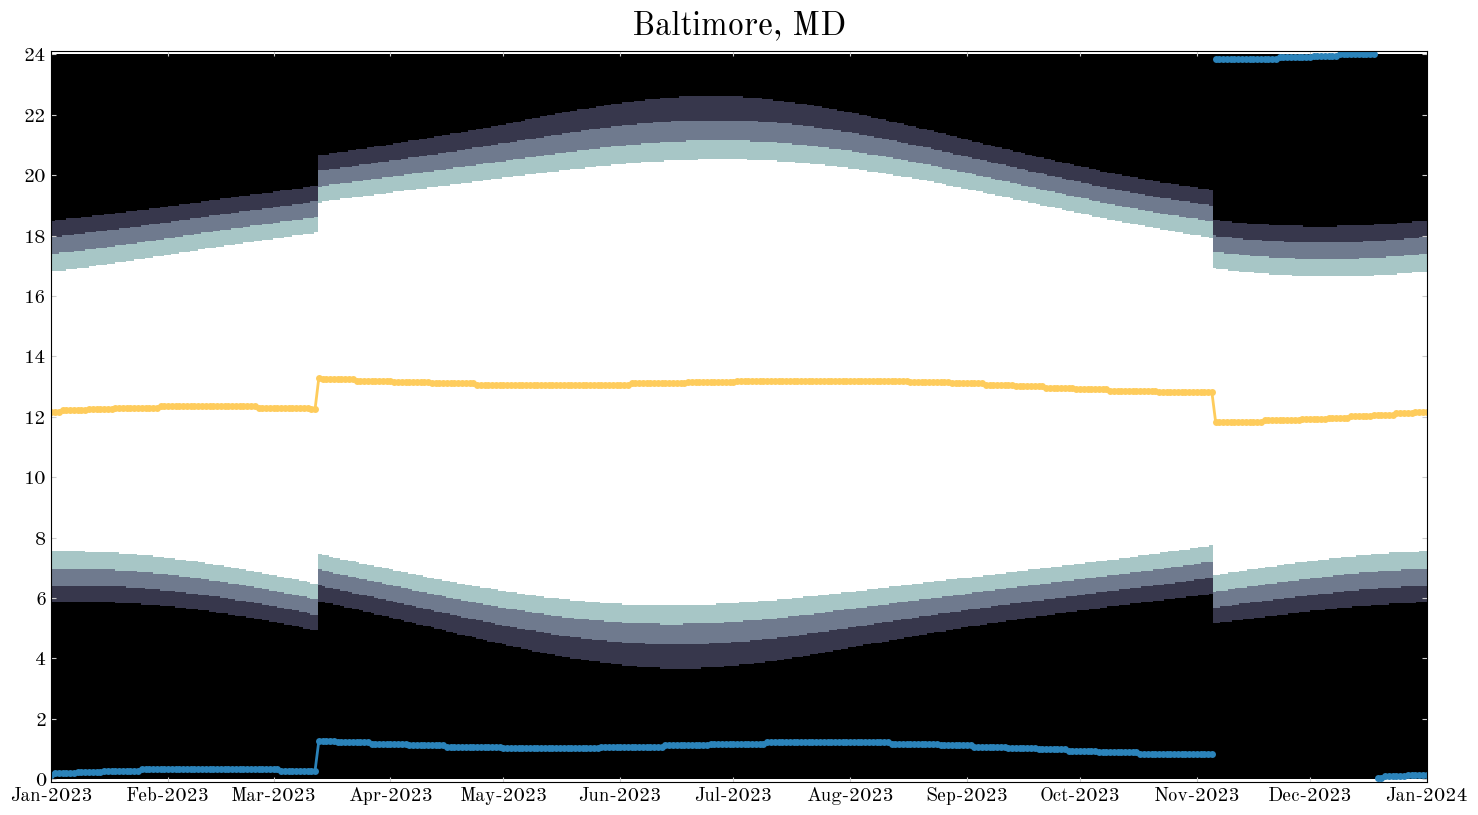

In [10]:
address = "Baltimore, MD"
loc = coord.EarthLocation.of_address(address)
tz = pytz.timezone("US/Eastern")
fig = sun_info_plot(loc, tz)
_ = fig.suptitle(address, fontsize=24, y=1.02)

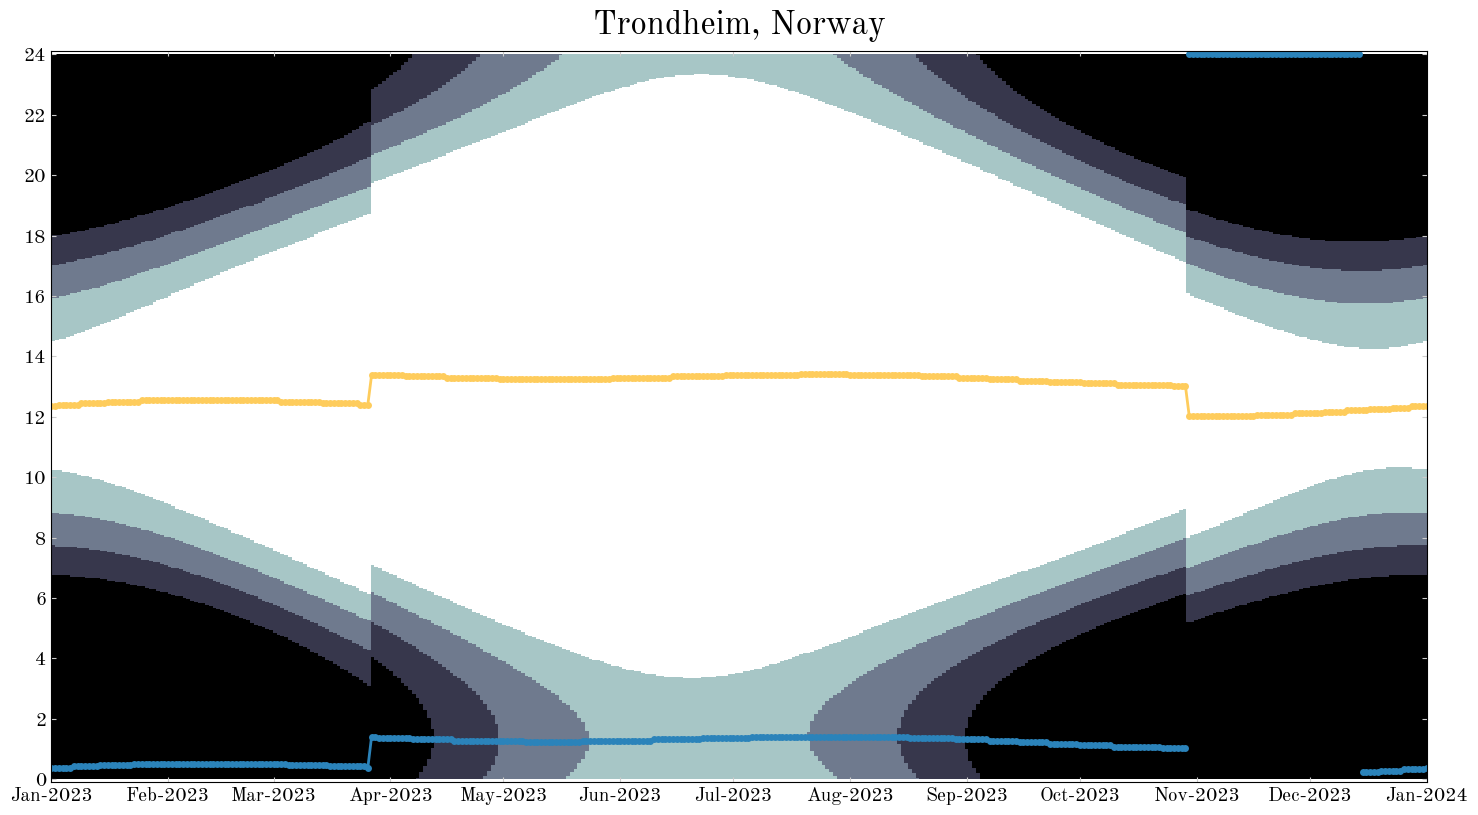

In [11]:
address = "Trondheim, Norway"
loc = coord.EarthLocation.of_address(address)
tz = pytz.timezone("Europe/Oslo")
fig = sun_info_plot(loc, tz)
_ = fig.suptitle(address, fontsize=24, y=1.02)

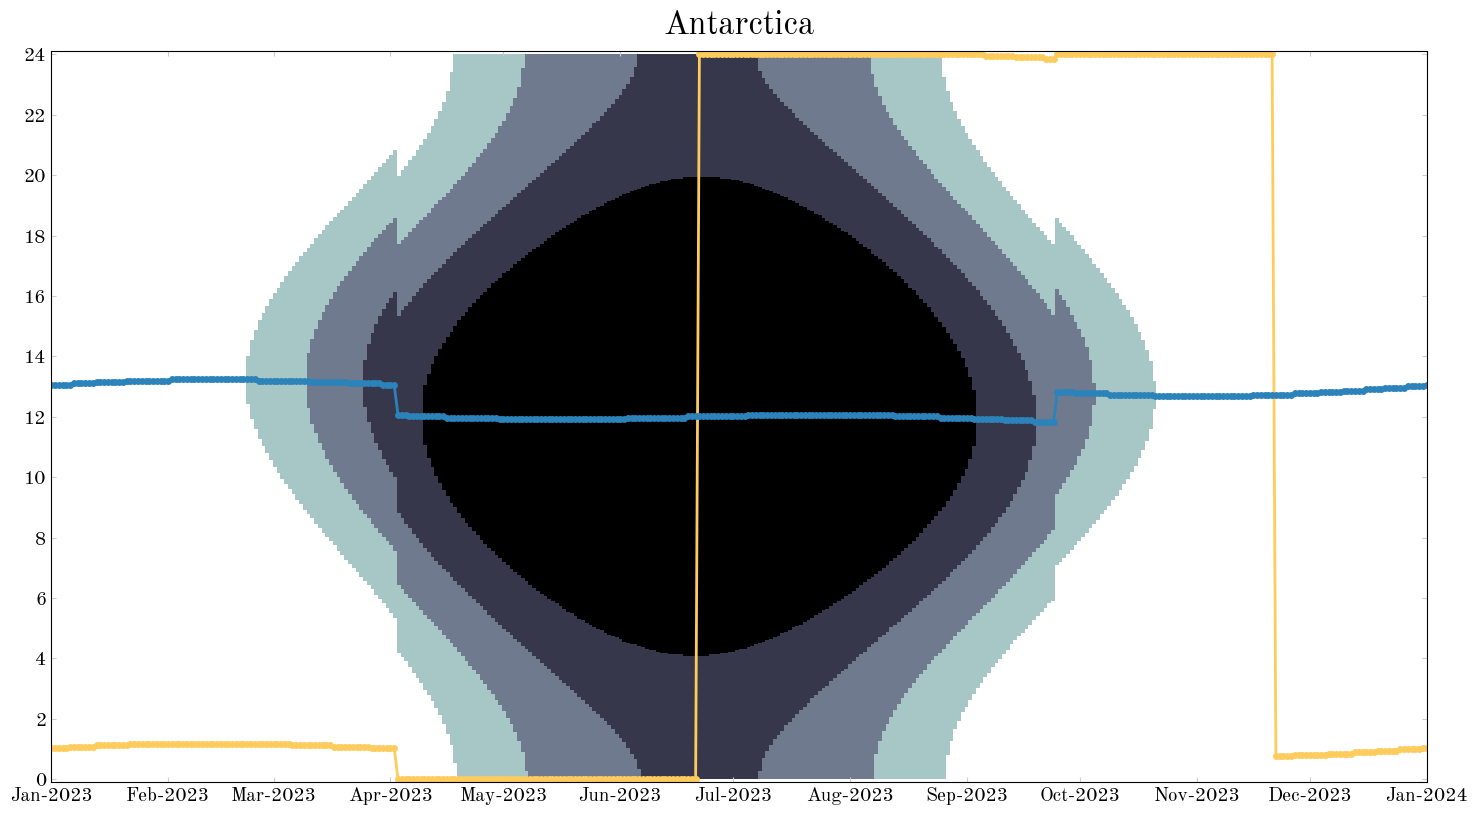

In [12]:
address = "Antarctica"
loc = coord.EarthLocation.of_address(address)
tz = pytz.timezone("Antarctica/McMurdo")
fig = sun_info_plot(loc, tz)
_ = fig.suptitle(address, fontsize=24, y=1.02);